In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import numpy as np
import matplotlib.pyplot as plt
%reload_ext tensorboard
(train_ds, test_ds), ds_info = tfds.load('cifar10', split =['train', 'test'], as_supervised = True, with_info = True)
train_ds = train_ds.take(5000)
test_ds = test_ds.take(500)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteRHR481/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteRHR481/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


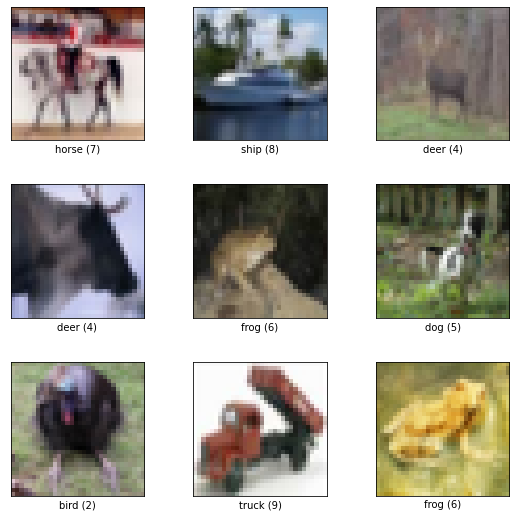

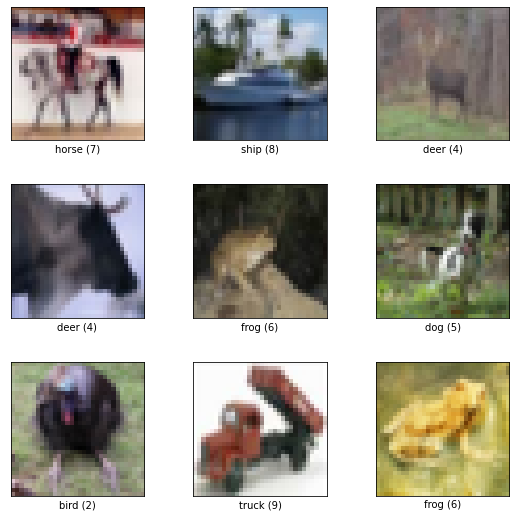

In [2]:
tfds.show_examples(train_ds, ds_info)

In [3]:
def prepare_cifar(mnist):
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    #mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(32)
    mnist = mnist.prefetch(20)
    return mnist

train_data = train_ds.apply(prepare_cifar)
test_data = test_ds.apply(prepare_cifar)

In [4]:
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [5]:
from tensorflow.python.keras.layers import Dense

class ConvNN(tf.keras.Model):
  def __init__(self):
    super(ConvNN,self).__init__()

    self.loss_function = tf.keras.losses.CategoricalCrossentropy()
    self.optimizer = tf.keras.optimizers.Adam()
    self.convlayer1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same',activation = 'relu',input_shape=(32,32,3))
    self.convlayer2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same',activation = 'relu')
    self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size = 2 , strides = 2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same',activation = 'relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same',activation = 'relu')
    self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size = 2 , strides = 2)

    self.convlayer5 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same',activation = 'relu')
    self.convlayer6 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same',activation = 'relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()
    self.fullycon = tf.keras.layers.Dense(256, activation = 'relu')
    self.out = tf.keras.layers.Dense(10, activation = 'softmax')

  @tf.function
  def call(self,input):
    output = input
    output = self.convlayer1(output)
    output = self.convlayer2(output)
    output = self.pooling1(output)
    output = self.convlayer3(output)
    output = self.convlayer4(output)
    output = self.pooling2(output)
    output = self.convlayer5(output)
    output = self.convlayer6(output)
    output = self.global_pool(output)
    output = self.fullycon(output)
    output = self.out(output)
    return output
                          





In [6]:
def train(model,input,target):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = model.loss_function(target,prediction)
    accuracy = np.argmax(target, axis = 1)== np.argmax(prediction,axis = 1)
    accuracy = np.mean(accuracy)
    gradients = tape.gradient(loss,model.trainable_variables)
  model.optimizer.apply_gradients(zip(gradients,model.trainable_variables))

  return loss,accuracy



In [7]:
def test(model,test_data):

  test_losses = []
  test_accuracies = []

  for (image,label) in test_data:
    prediction = model(image,training = False)
    loss = model.loss_function(label,prediction)
    accuracy = np.argmax(label,axis =1)== np.argmax(prediction,axis = 1)
    accuracy = np.mean(accuracy)
    test_accuracies.append(np.mean(accuracy))
    test_losses.append(loss)
  
  test_loss = tf.reduce_mean(test_losses)
  test_accuracy = tf.reduce_mean(test_accuracies)
  return test_loss,test_accuracy


In [8]:
def training_loop(model,n_epochs,train_ds,test_ds):

  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  train_loss,train_accuracy = test(model,train_ds)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  test_loss,test_accuracy = test(model,test_ds)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  for n in range(n_epochs):
    print(f'Epoch: {str(n)} starting with accuracy {test_accuracies[-1]}')

    epoch_losses = []
    epoch_accuracies = []
    for img, target in train_ds:
      train_loss,train_accuracy = train(model,img,target)
      epoch_losses.append(train_loss)
      epoch_accuracies.append(train_accuracies)
    
    train_loss = tf.reduce_mean(epoch_losses)
    train_accuracy = tf.reduce_mean(epoch_accuracies)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    test_loss, test_accuracy = test(model,test_ds)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

  return train_losses,train_accuracies,test_losses,test_accuracies








In [9]:
def visualize(train_losses,train_accuracies,test_losses,test_accuracies):

  fig , axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize = (10,6))

  graph1 = axes[0].plot(train_losses,color = 'blue')
  graph2 = axes[0].plot(test_losses,color = 'red')

  graph3 = axes[1].plot(train_accuracies,color = 'blue')
  graph4 = axes[1].plot(test_accuracies,color = 'red')

  axes[0].set(ylim = [0,5], xlabel = 'epoch', ylabel = 'loss')
  axes[1].set(ylim = [0,1], xlabel = 'epoch', ylabel = 'accuracy')

  axes[0].legend(['Training','Test'])
  axes[1].legend(['Training','Test'])
  


  axes[0].set_title('Loss')
  axes[1].set_title('Accuracy')

  plt.show()
  

Epoch: 0 starting with accuracy 0.091015625
Epoch: 1 starting with accuracy 0.2359375
Epoch: 2 starting with accuracy 0.25703125
Epoch: 3 starting with accuracy 0.366015625
Epoch: 4 starting with accuracy 0.4328125
Epoch: 5 starting with accuracy 0.480859375
Epoch: 6 starting with accuracy 0.4953125
Epoch: 7 starting with accuracy 0.522265625
Epoch: 8 starting with accuracy 0.54140625
Epoch: 9 starting with accuracy 0.5578125


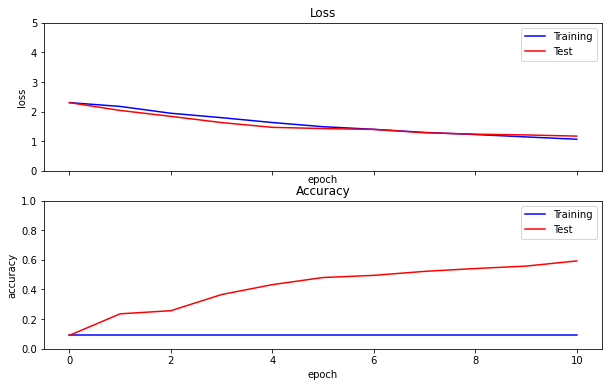

In [10]:
model1 = ConvNN()
train_losses,train_accuracies,test_losses,test_accuracies = training_loop(model = model1,n_epochs=10,train_ds = train_data ,test_ds = test_data)
visualize(train_losses,train_accuracies,test_losses,test_accuracies)
